## Import Libraries & Data

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.regression import *
import math

In [48]:
df = pd.read_csv("Conspan July 24.csv")

In [49]:
df.head()

,Employee ID,Age,Department,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRotation,FeedbackFromManager,Mentoring,Autonomy,JobRole,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,RelationshipSatisfaction,Tools,TotalWorkingYears,Training,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Performance
0,64,25.0,Production,2,3.0,1.0,Male,3,1,1,L,N,N,Machinists,4031.0,5.0,No,13.0,3.0,L,6.0,N,3.0,2.0,2.0,0.0,2.0,47
1,339,32.0,Research & Development,7,4.0,2.0,Female,4,1,2,L,Y,Y,Research and Design Specialists,3312.0,6.0,No,17.0,4.0,L,6.0,Y,3.0,3.0,2.0,0.0,2.0,61
2,376,33.0,Research & Development,9,3.0,4.0,Male,2,3,2,H,Y,Y,Customercare Representative,7119.0,2.0,No,15.0,3.0,L,9.0,Y,3.0,3.0,2.0,1.0,2.0,62
3,429,36.0,Sales,18,2.0,2.0,Male,2,3,4,H,N,Y,Sales Executive,7596.0,1.0,No,13.0,2.0,H,10.0,Y,3.0,10.0,9.0,9.0,0.0,82
4,441,32.0,Research & Development,17,3.0,4.0,Male,3,2,4,L,N,Y,Research and Design Specialists,5470.0,9.0,No,13.0,3.0,L,10.0,Y,2.0,9.0,5.0,1.0,6.0,67


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1201 entries, 0 to 1200
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Employee ID               1201 non-null   int64  
 1   Age                       1199 non-null   float64
 2   Department                1201 non-null   object 
 3   DistanceFromHome          1201 non-null   int64  
 4   Education                 1198 non-null   float64
 5   EnvironmentSatisfaction   1199 non-null   float64
 6   Gender                    1201 non-null   object 
 7   JobInvolvement            1201 non-null   int64  
 8   JobLevel                  1201 non-null   int64  
 9   JobRotation               1201 non-null   int64  
 10  FeedbackFromManager       1200 non-null   object 
 11  Mentoring                 1200 non-null   object 
 12  Autonomy                  1200 non-null   object 
 13  JobRole                   1200 non-null   object 
 14  MonthlyI

## Data Quality Checks

In [51]:
def summarize_schema(df: pd.DataFrame) -> pd.DataFrame:
    info = []
    for col in df.columns:
        dtype = df[col].dtype
        inferred = pd.api.types.infer_dtype(df[col], skipna=True)
        info.append({
            'column': col,
            'dtype': str(dtype),
            'inferred': inferred,
            'non_null_count': int(df[col].notna().sum()),
            'null_count': int(df[col].isna().sum()),
            'null_pct': float(df[col].isna().mean()*100),
            'n_unique': int(df[col].nunique(dropna=True))
        })
    return pd.DataFrame(info).sort_values(['dtype','column']).reset_index(drop=True)

In [52]:
def missingness_report(df: pd.DataFrame) -> pd.DataFrame:
    miss = df.isna().mean().sort_values(ascending=False)*100
    return miss.to_frame('missing_pct').reset_index().rename(columns={'index': 'column'})

In [53]:
def duplicate_report(df: pd.DataFrame) -> pd.DataFrame:
    dup_rows = df.duplicated(keep=False)
    n_dups = int(dup_rows.sum())
    return pd.DataFrame({'metric':['duplicate_rows'], 'value':[n_dups]})

In [54]:
def numeric_outlier_summary(df: pd.DataFrame) -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns
    rows = []
    for col in num_cols:
        s = df[col].dropna()
        if s.empty:
            rows.append({'column': col, 'lower_bound': np.nan, 'upper_bound': np.nan,
                         'outlier_count': 0, 'outlier_pct': 0.0})
            continue
        q1 = s.quantile(0.25)
        q3 = s.quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5*iqr
        upper = q3 + 1.5*iqr
        mask = (df[col] < lower) | (df[col] > upper)
        rows.append({
            'column': col,
            'lower_bound': float(lower),
            'upper_bound': float(upper),
            'outlier_count': int(mask.sum()),
            'outlier_pct': float(mask.mean()*100)
        })
    return pd.DataFrame(rows)

In [55]:
def detect_numeric_strings(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for col in df.columns:
        if df[col].dtype == 'object':
            s = df[col].astype(str).str.strip()
            s_repl = s.replace({'': np.nan, 'nan': np.nan, 'None': np.nan})
            numeric_like = s_repl.str.match(r'^[-+]?\\d+(\\.\\d+)?$')
            n_numeric_like = int(numeric_like.fillna(False).sum())
            rows.append({
                'column': col,
                'object_numeric_like': n_numeric_like,
                'object_total': int(len(s)),
                'numeric_like_pct': float(numeric_like.mean(skipna=True)*100 if numeric_like.notna().any() else 0.0)
            })
    return pd.DataFrame(rows)

In [56]:
def string_quality(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for col in df.select_dtypes(include=['object']).columns:
        s = df[col].astype(str)
        lens = s.str.len()
        leading_ws = s.str.match(r'^\\s').sum()
        trailing_ws = s.str.match(r'.*\\s$').sum()
        non_printable = s.str.contains(r'[^\\x20-\\x7E\\n\\r\\t]', regex=True).sum()
        rows.append({
            'column': col,
            'min_len': int(lens.min()),
            'p5_len': float(lens.quantile(0.05)),
            'median_len': float(lens.median()),
            'p95_len': float(lens.quantile(0.95)),
            'max_len': int(lens.max()),
            'leading_ws_count': int(leading_ws),
            'trailing_ws_count': int(trailing_ws),
            'non_printable_count': int(non_printable)
        })
    return pd.DataFrame(rows)

In [57]:
def cardinality_report(df: pd.DataFrame, high_card_threshold: int = 50) -> pd.DataFrame:
    rows = []
    for col in df.columns:
        nunique = int(df[col].nunique(dropna=True))
        rows.append({'column': col, 'unique': nunique, 'high_cardinality': bool(nunique > high_card_threshold)})
    return pd.DataFrame(rows).sort_values('unique', ascending=False).reset_index(drop=True)

In [58]:
def numeric_summary(df: pd.DataFrame) -> pd.DataFrame:
    num = df.select_dtypes(include=[np.number])
    if num.empty:
        return pd.DataFrame()
    desc = num.describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]).T
    desc['missing_pct'] = 100*(1 - desc['count']/len(df))
    return desc.reset_index().rename(columns={'index':'column'})

In [59]:
schema = summarize_schema(df)
missing = missingness_report(df)
dups = duplicate_report(df)
outliers = numeric_outlier_summary(df)
numstr = detect_numeric_strings(df)
strq = string_quality(df)
card = cardinality_report(df)
numsum = numeric_summary(df)

In [60]:
missing_show = missing
missing_show['missing_pct'] = missing_show['missing_pct'].round(2)
missing_show

,column,missing_pct
0,MonthlyIncome,0.92
1,YearsWithCurrManager,0.25
2,YearsSinceLastPromotion,0.25
3,Education,0.25
4,YearsInCurrentRole,0.25
5,YearsAtCompany,0.25
6,PercentSalaryHike,0.25
7,Age,0.17
8,EnvironmentSatisfaction,0.17
9,WorkLifeBalance,0.17


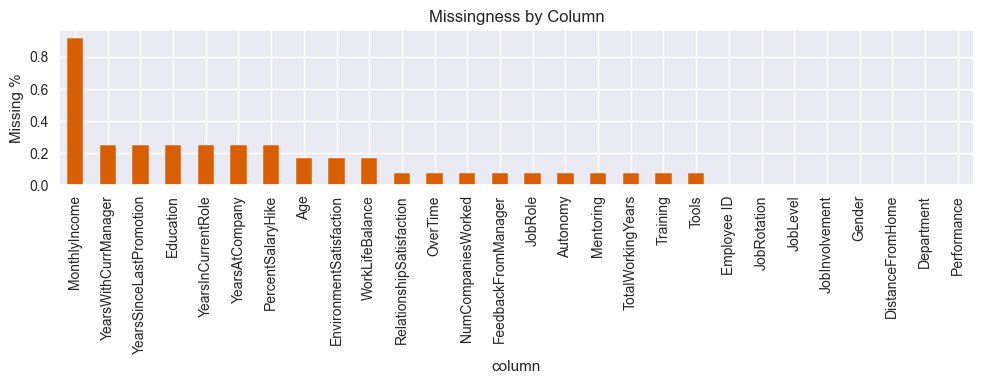

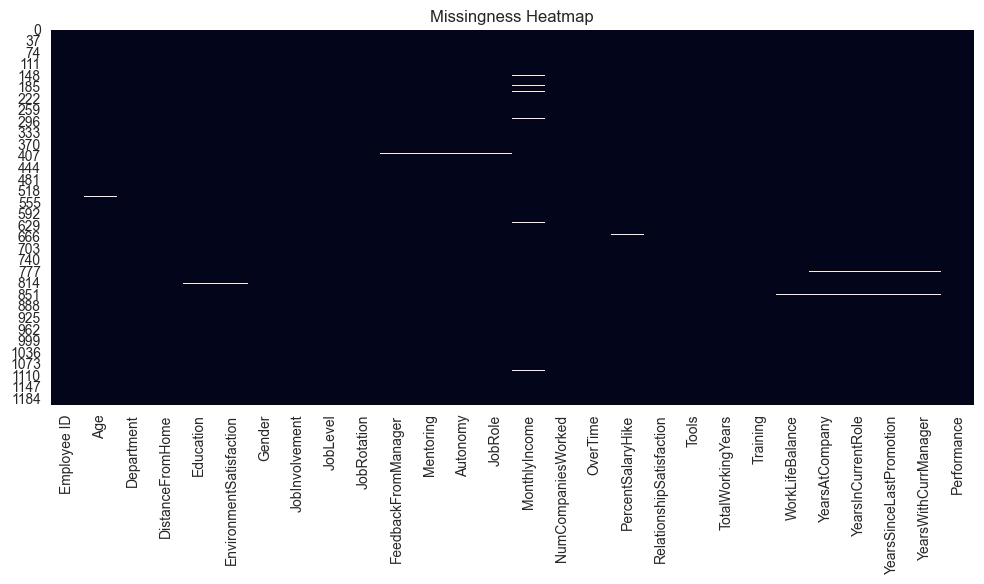

In [61]:
plt.figure(figsize=(10,4))
missing.set_index('column')['missing_pct'].plot(kind='bar', color='#d95f02')
plt.ylabel('Missing %')
plt.title('Missingness by Column')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(df.isna(), cbar=False)
plt.title('Missingness Heatmap')
plt.tight_layout()
plt.show()

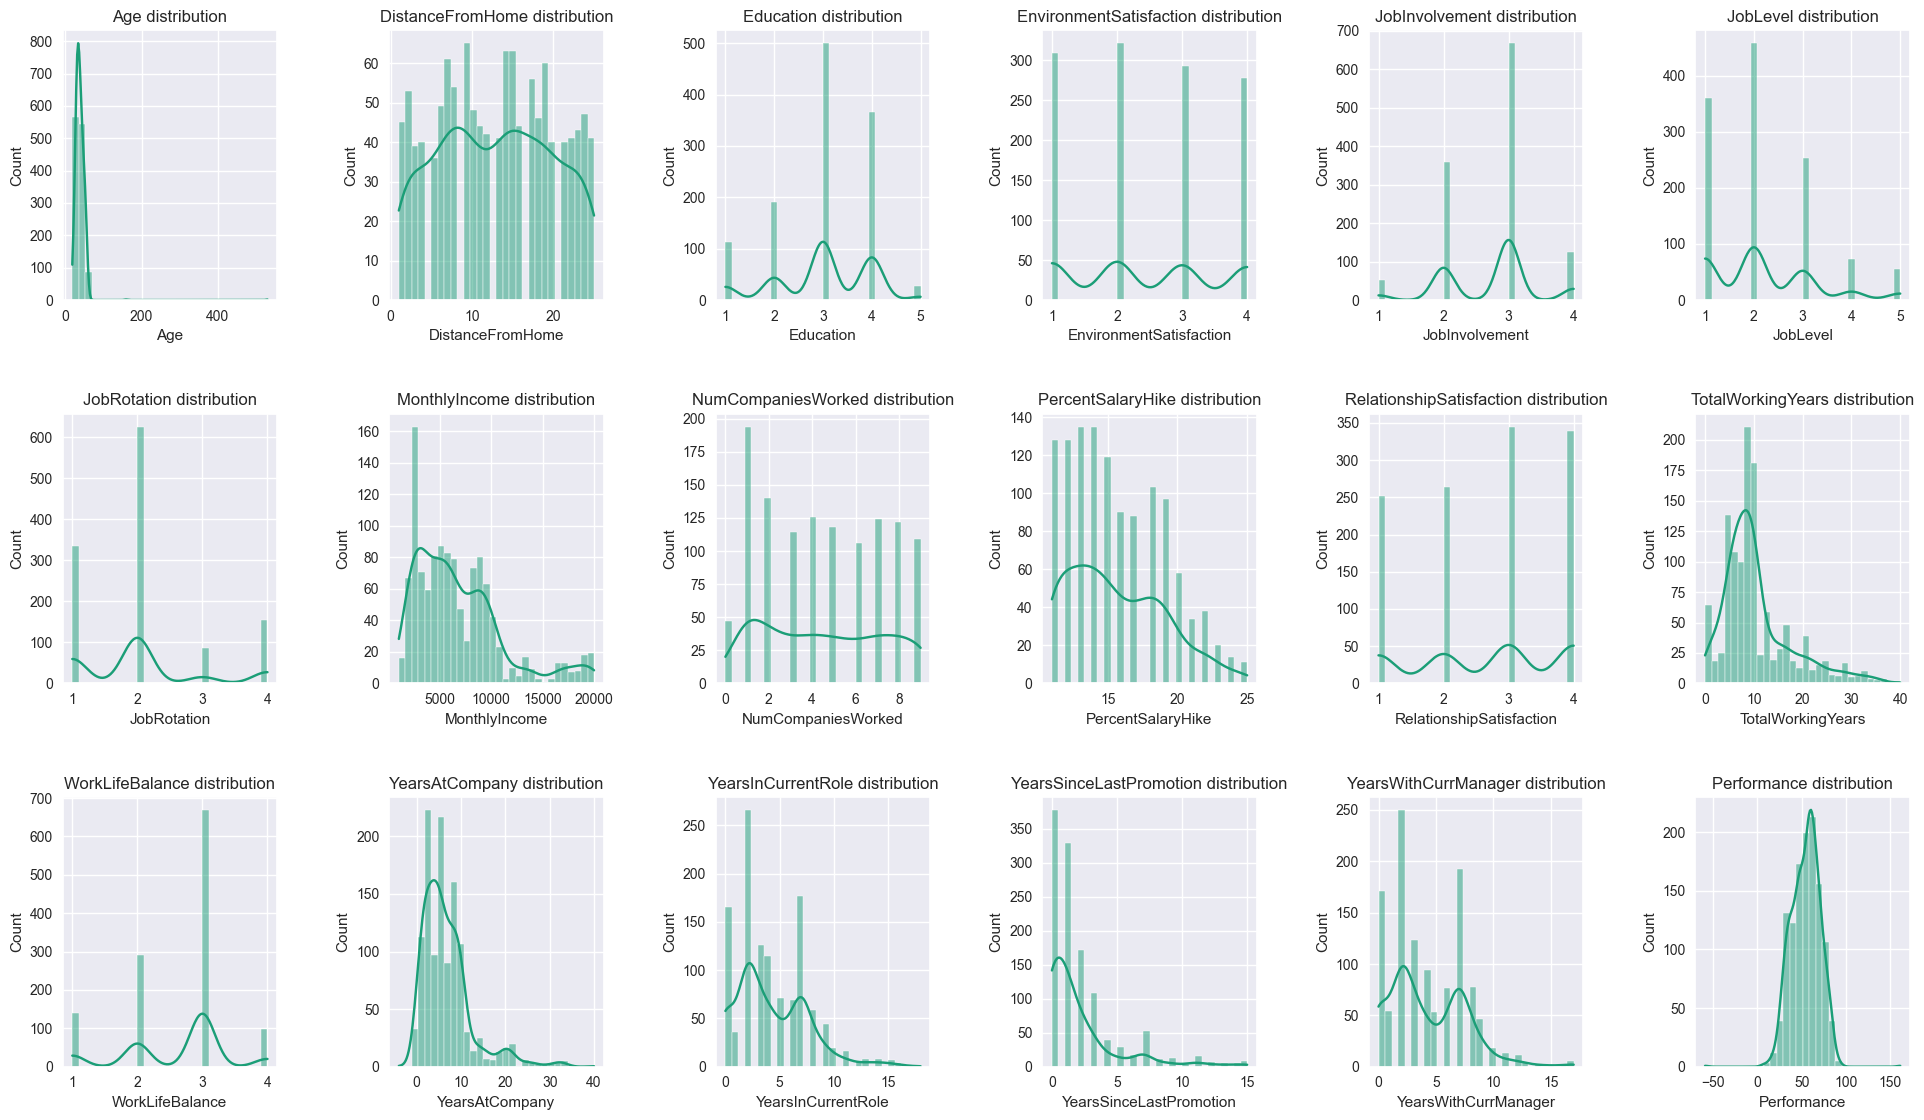

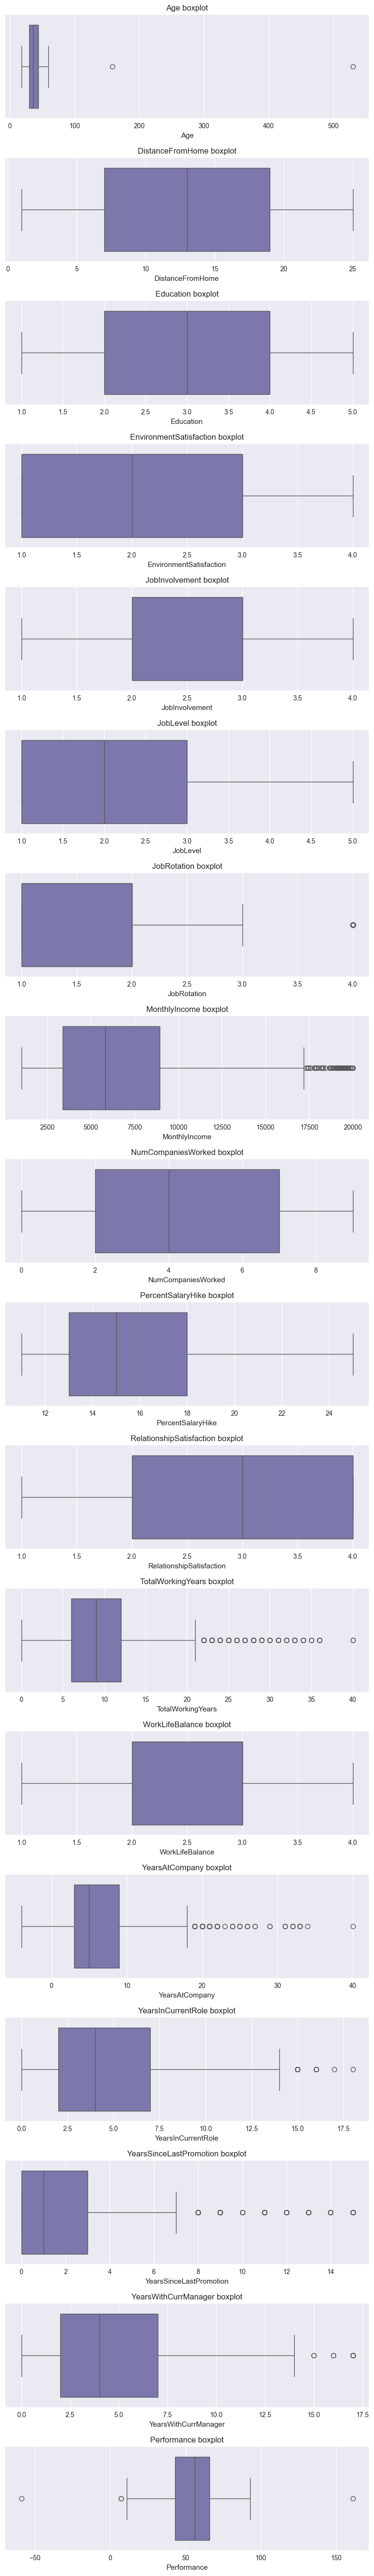

In [62]:
num_cols = [col for col in df.select_dtypes(include=[np.number]).columns if col != 'Employee ID']
if num_cols:
    num_rows = math.ceil(len(num_cols) / 6)
    fig, axes = plt.subplots(num_rows, 6, figsize=(5 * 4, num_rows * 4))
    axes = axes.flatten()
    for i, col in enumerate(num_cols):
        sns.histplot(df[col], bins=30, kde=True, ax=axes[i], color='#1b9e77')
        axes[i].set_title(f'{col} distribution', fontsize=12)
        axes[i].tick_params(axis='both', which='major', labelsize=10)
    for j in range(len(num_cols), len(axes)):
        axes[j].set_visible(False)
    plt.tight_layout(pad=3.0); plt.show()

    fig, axes = plt.subplots(len(num_cols), 1, figsize=(8, 3*len(num_cols)))
    if len(num_cols) == 1: axes = [axes]
    for ax, col in zip(axes, num_cols):
        sns.boxplot(x=df[col], ax=ax, color='#7570b3')
        ax.set_title(f'{col} boxplot')
    plt.tight_layout()
    plt.show()

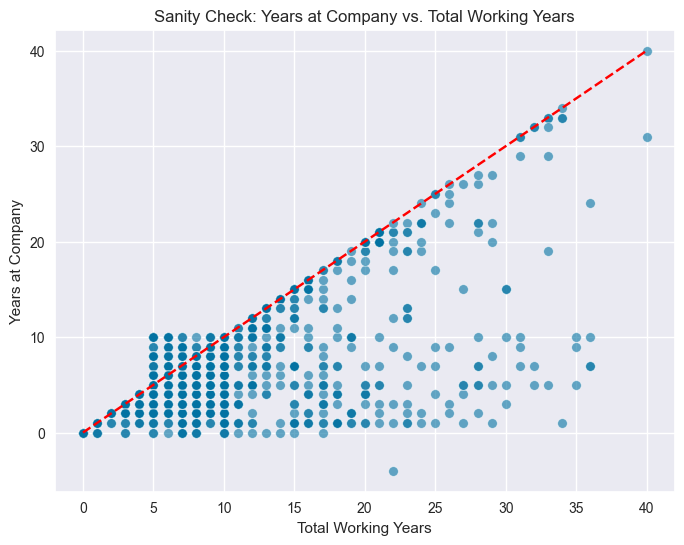

In [63]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='TotalWorkingYears', y='YearsAtCompany', alpha=0.6)
plt.plot([0, df['TotalWorkingYears'].max()], [0, df['TotalWorkingYears'].max()], color='red', linestyle='--')
plt.title('Sanity Check: Years at Company vs. Total Working Years')
plt.xlabel('Total Working Years')
plt.ylabel('Years at Company')
plt.grid(True)
plt.show()

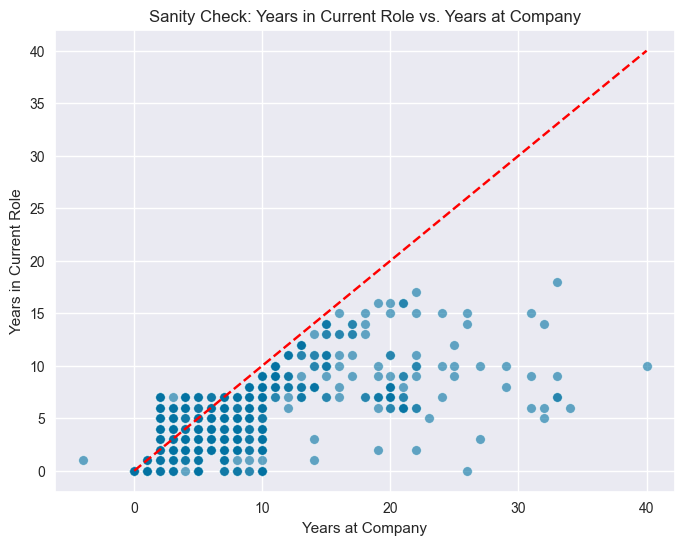

In [64]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='YearsAtCompany', y='YearsInCurrentRole', alpha=0.6)
plt.plot([0, df['YearsAtCompany'].max()], [0, df['YearsAtCompany'].max()], color='red', linestyle='--')
plt.title('Sanity Check: Years in Current Role vs. Years at Company')
plt.xlabel('Years at Company')
plt.ylabel('Years in Current Role')
plt.grid(True)
plt.show()

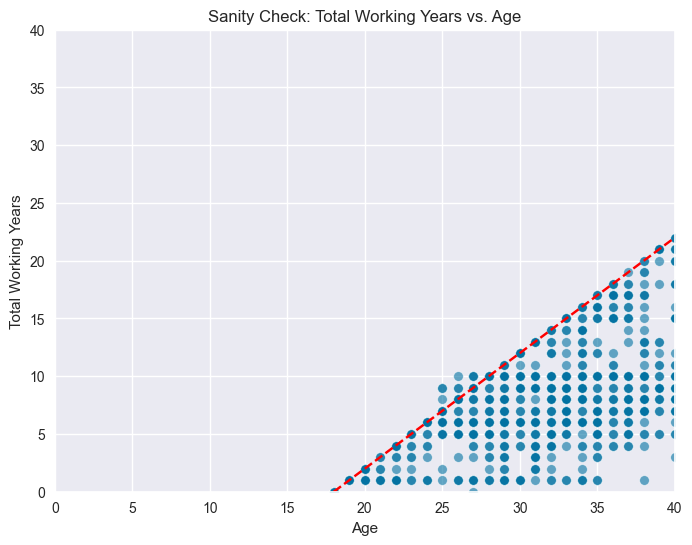

In [65]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Age', y='TotalWorkingYears', alpha=0.6)
plt.plot([18, 100], [0, 82], color='red', linestyle='--')
plt.title('Sanity Check: Total Working Years vs. Age')
plt.xlabel('Age')
plt.ylabel('Total Working Years')
plt.xlim(0, 40)
plt.ylim(0, 40)
plt.grid(True)
plt.show()

## Data Cleaning using Data Dict

In [66]:
data_dict = {
    "EmployeeID": {"type": "int"},
    "Age": {"min": 18, "max": 60},
    "Department": {"allowed": ["Human Resources", "IT Support", "Production","Research and Development", "Finance", "Sales"]},
    "DistanceFromHome": {"min": 1, "max": 25},
    "Education": {"min": 1, "max": 5},
    "EnvironmentSatisfaction": {"min": 1, "max": 4},
    "Gender": {"allowed": ["Male", "Female"]},
    "JobInvolvement": {"min": 1, "max": 4},
    "JobLevel": {"min": 1, "max": 5},
    "JobRole": {"type": "string"},
    "JobRotation": {"min": 1, "max": 4},
    "FeedbackFromManager": {"allowed": ["H", "L"]},
    "Mentoring": {"allowed": ["Y", "N"]},
    "MonthlyIncome": {"min": 0, "max": None},
    "NumCompaniesWorked": {"min": 0, "max": None},
    "OverTime": {"allowed": ["Yes", "No"]},
    "Performance": {"min": 0, "max": 100},
    "PercentSalaryHike": {"min": 0, "max": 100},
    "RelationshipSatisfaction": {"min": 1, "max": 4},
    "TotalWorkingYears": {"min": 0, "max": None},
    "WorkLifeBalance": {"min": 1, "max": 4},
    "YearsAtCompany": {"min": 0, "max": None},
    "YearsInCurrentRole": {"min": 0, "max": None},
    "YearsSinceLastPromotion": {"min": 0, "max": None},
    "YearsWithCurrManager": {"min": 0, "max": None},
    "Autonomy": {"allowed": ["H", "L"]},
    "Tools": {"allowed": ["L", "H"]},
    "Training": {"allowed": ["Y", "N"]}
}

In [67]:
def validate_dataframe(df, data_dict):
    invalid_flags = pd.DataFrame(False, index=df.index, columns=df.columns)

    for col, rules in data_dict.items():
        if col not in df.columns:
            continue

        if "min" in rules or "max" in rules:
            if "min" in rules and rules["min"] is not None:
                invalid_flags[col] |= df[col] < rules["min"]
            if "max" in rules and rules["max"] is not None:
                invalid_flags[col] |= df[col] > rules["max"]

        if "allowed" in rules:
            invalid_flags[col] |= ~df[col].isin(rules["allowed"])

    return invalid_flags

In [68]:
invalids = validate_dataframe(df, data_dict)
invalids

,Employee ID,Age,Department,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRotation,FeedbackFromManager,Mentoring,Autonomy,JobRole,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,RelationshipSatisfaction,Tools,TotalWorkingYears,Training,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Performance
0,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1196,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1197,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1198,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1199,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [69]:
rows_with_issues = df[invalids.any(axis=1)]
rows_with_issues

,Employee ID,Age,Department,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRotation,FeedbackFromManager,Mentoring,Autonomy,JobRole,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,RelationshipSatisfaction,Tools,TotalWorkingYears,Training,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Performance
0,64,25.0,Production,2,3.0,1.0,Male,3,1,1,L,N,N,Machinists,4031.0,5.0,No,13.0,3.0,L,6.0,N,3.0,2.0,2.0,0.0,2.0,47
1,339,32.0,Research & Development,7,4.0,2.0,Female,4,1,2,L,Y,Y,Research and Design Specialists,3312.0,6.0,No,17.0,4.0,L,6.0,Y,3.0,3.0,2.0,0.0,2.0,61
2,376,33.0,Research & Development,9,3.0,4.0,Male,2,3,2,H,Y,Y,Customercare Representative,7119.0,2.0,No,15.0,3.0,L,9.0,Y,3.0,3.0,2.0,1.0,2.0,62
3,429,36.0,Sales,18,2.0,2.0,Male,2,3,4,H,N,Y,Sales Executive,7596.0,1.0,No,13.0,2.0,H,10.0,Y,3.0,10.0,9.0,9.0,0.0,82
4,441,32.0,Research & Development,17,3.0,4.0,Male,3,2,4,L,N,Y,Research and Design Specialists,5470.0,9.0,No,13.0,3.0,L,10.0,Y,2.0,9.0,5.0,1.0,6.0,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1196,77703,38.0,Human Resources,6,3.0,1.0,Male,3,1,2,L,N,Y,Human Resources,2592.0,8.0,No,13.0,4.0,H,13.0,Y,3.0,11.0,10.0,3.0,8.0,70
1197,77743,39.0,Research & Development,10,1.0,4.0,Female,2,4,2,L,Y,Y,Manufacturing Director,12742.0,6.0,No,16.0,3.0,L,21.0,Y,3.0,21.0,6.0,11.0,8.0,60
1198,78090,56.0,Research & Development,20,3.0,1.0,Female,3,1,1,L,N,N,Research and Design Specialists,2942.0,2.0,No,19.0,2.0,L,18.0,N,3.0,5.0,4.0,0.0,3.0,35
1199,78175,38.0,Sales,15,2.0,2.0,Female,3,2,2,L,N,Y,Sales Executive,6893.0,6.0,No,15.0,4.0,L,11.0,Y,3.0,7.0,7.0,1.0,7.0,73


In [70]:
def summarize_invalids(df, invalid_flags):
    summary = {}
    for col in df.columns:
        if col in invalid_flags.columns:
            invalid_count = invalid_flags[col].sum()
            if invalid_count > 0:
                summary[col] = {
                    "invalid_count": invalid_count,
                    "total_rows": len(df),
                    "percent_invalid": round((invalid_count / len(df)) * 100, 2)
                }
    return pd.DataFrame(summary).T.sort_values("percent_invalid", ascending=False)

In [71]:
invalids = validate_dataframe(df, data_dict)
summary = summarize_invalids(df, invalids)
summary

,invalid_count,total_rows,percent_invalid
Autonomy,1201.0,1201.0,100.00
Department,489.0,1201.0,40.72
Age,2.0,1201.0,0.17
Performance,2.0,1201.0,0.17
FeedbackFromManager,1.0,1201.0,0.08
Mentoring,1.0,1201.0,0.08
OverTime,1.0,1201.0,0.08
Tools,1.0,1201.0,0.08
Training,1.0,1201.0,0.08
YearsAtCompany,1.0,1201.0,0.08


In [72]:
df.head()

,Employee ID,Age,Department,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRotation,FeedbackFromManager,Mentoring,Autonomy,JobRole,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,RelationshipSatisfaction,Tools,TotalWorkingYears,Training,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Performance
0,64,25.0,Production,2,3.0,1.0,Male,3,1,1,L,N,N,Machinists,4031.0,5.0,No,13.0,3.0,L,6.0,N,3.0,2.0,2.0,0.0,2.0,47
1,339,32.0,Research & Development,7,4.0,2.0,Female,4,1,2,L,Y,Y,Research and Design Specialists,3312.0,6.0,No,17.0,4.0,L,6.0,Y,3.0,3.0,2.0,0.0,2.0,61
2,376,33.0,Research & Development,9,3.0,4.0,Male,2,3,2,H,Y,Y,Customercare Representative,7119.0,2.0,No,15.0,3.0,L,9.0,Y,3.0,3.0,2.0,1.0,2.0,62
3,429,36.0,Sales,18,2.0,2.0,Male,2,3,4,H,N,Y,Sales Executive,7596.0,1.0,No,13.0,2.0,H,10.0,Y,3.0,10.0,9.0,9.0,0.0,82
4,441,32.0,Research & Development,17,3.0,4.0,Male,3,2,4,L,N,Y,Research and Design Specialists,5470.0,9.0,No,13.0,3.0,L,10.0,Y,2.0,9.0,5.0,1.0,6.0,67


Autonomy has "Y/N" values per the dataset, but the data dictionary specifies "H/L" values. Discuss w/ team.

In [73]:
df.loc[~df["Department"].isin(data_dict["Department"]["allowed"]), "Department"].unique().tolist()

['Research & Development', 'IT_Support', 'R&D', 'Fin']

In [74]:
print(data_dict["Department"]["allowed"])

['Human Resources', 'IT Support', 'Production', 'Research and Development', 'Finance', 'Sales']


Invalid departments are just abbreviations or minor typos. Can be replaced.

In [75]:
autonomy_corrections = {
    "Y": "H",
    "N": "L"
}
df["Autonomy"] = df["Autonomy"].replace(autonomy_corrections)

In [76]:
dept_corrections = {
    "Research & Development": "Research and Development",
    "IT_Support": "IT Support",
    "R&D": "Research and Development",
    "Fin": "Finance"
}

df["Department"] = df["Department"].replace(dept_corrections)

In [77]:
invalids = validate_dataframe(df, data_dict)
summary = summarize_invalids(df, invalids)
summary

,invalid_count,total_rows,percent_invalid
Age,2.0,1201.0,0.17
Performance,2.0,1201.0,0.17
FeedbackFromManager,1.0,1201.0,0.08
Mentoring,1.0,1201.0,0.08
Autonomy,1.0,1201.0,0.08
OverTime,1.0,1201.0,0.08
Tools,1.0,1201.0,0.08
Training,1.0,1201.0,0.08
YearsAtCompany,1.0,1201.0,0.08


In [78]:
df.sort_values(by="Age", ascending=False)

,Employee ID,Age,Department,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRotation,FeedbackFromManager,Mentoring,Autonomy,JobRole,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,RelationshipSatisfaction,Tools,TotalWorkingYears,Training,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Performance
1102,71078,530.0,Finance,7,3.0,2.0,Male,2,3,2,L,N,H,Accountant,9497.0,7.0,No,15.0,4.0,L,10.0,N,1.0,8.0,2.0,2.0,6.0,50
174,10330,159.0,Sales,13,2.0,2.0,Male,3,3,2,L,Y,H,Manager,11904.0,9.0,Yes,14.0,3.0,L,14.0,Y,1.0,6.0,4.0,0.0,4.0,66
800,50946,60.0,Research and Development,12,3.0,1.0,Female,3,5,2,L,N,H,Manager,19566.0,5.0,No,11.0,4.0,L,33.0,N,1.0,29.0,8.0,11.0,10.0,44
574,35469,60.0,Sales,21,4.0,1.0,Male,3,2,1,L,N,L,Sales Executive,5405.0,6.0,No,14.0,4.0,L,10.0,N,3.0,2.0,2.0,2.0,2.0,32
168,9953,59.0,Research and Development,16,4.0,4.0,Male,3,3,2,L,Y,H,Manufacturing Director,10512.0,9.0,No,12.0,4.0,H,25.0,N,2.0,9.0,7.0,5.0,4.0,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051,67269,18.0,Production,19,3.0,4.0,Female,3,1,4,L,N,H,Machinists,1611.0,6.0,No,15.0,3.0,L,0.0,Y,4.0,0.0,0.0,0.0,0.0,65
1004,64486,18.0,Production,4,3.0,3.0,Male,3,1,2,L,N,L,Machinists,1420.0,1.0,No,13.0,3.0,L,0.0,N,3.0,0.0,0.0,0.0,0.0,42
604,38562,18.0,Sales,9,3.0,2.0,Male,3,1,1,L,N,L,Sales Representative,1878.0,1.0,Yes,14.0,4.0,L,0.0,N,3.0,0.0,0.0,0.0,0.0,39
532,32344,NaN,Research and Development,3,3.0,1.0,Male,2,2,2,H,Y,H,Customercare Representative,4240.0,5.0,No,13.0,4.0,L,19.0,Y,3.0,2.0,2.0,2.0,2.0,53


In [79]:
valid_rows_mask = pd.Series(True, index=df.index)

# 2. Loop through the rules and update the mask
for column, rules in data_dict.items():
    if column in df.columns:
        if 'min' in rules and rules['min'] is not None:
            valid_rows_mask &= (df[column] >= rules['min'])
        if 'max' in rules and rules['max'] is not None:
            valid_rows_mask &= (df[column] <= rules['max'])
        if 'allowed' in rules:
            valid_rows_mask &= (df[column].isin(rules['allowed']))

# 3. Create the new, filtered DataFrame
filtered_df = df[valid_rows_mask].copy()

# Optional: See how many rows were removed
print(f"Original DataFrame shape: {df.shape}")
print(f"Filtered DataFrame shape: {filtered_df.shape}")

Original DataFrame shape: (1201, 28)
Filtered DataFrame shape: (1172, 28)


In [80]:
filtered_df.head()

,Employee ID,Age,Department,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRotation,FeedbackFromManager,Mentoring,Autonomy,JobRole,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,RelationshipSatisfaction,Tools,TotalWorkingYears,Training,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Performance
0,64,25.0,Production,2,3.0,1.0,Male,3,1,1,L,N,L,Machinists,4031.0,5.0,No,13.0,3.0,L,6.0,N,3.0,2.0,2.0,0.0,2.0,47
1,339,32.0,Research and Development,7,4.0,2.0,Female,4,1,2,L,Y,H,Research and Design Specialists,3312.0,6.0,No,17.0,4.0,L,6.0,Y,3.0,3.0,2.0,0.0,2.0,61
2,376,33.0,Research and Development,9,3.0,4.0,Male,2,3,2,H,Y,H,Customercare Representative,7119.0,2.0,No,15.0,3.0,L,9.0,Y,3.0,3.0,2.0,1.0,2.0,62
3,429,36.0,Sales,18,2.0,2.0,Male,2,3,4,H,N,H,Sales Executive,7596.0,1.0,No,13.0,2.0,H,10.0,Y,3.0,10.0,9.0,9.0,0.0,82
4,441,32.0,Research and Development,17,3.0,4.0,Male,3,2,4,L,N,H,Research and Design Specialists,5470.0,9.0,No,13.0,3.0,L,10.0,Y,2.0,9.0,5.0,1.0,6.0,67


In [81]:
filtered_out_df = df[~valid_rows_mask].copy()
reasons_for_filtering = []

for index, row in filtered_out_df.iterrows():
    reasons = []
    for column, rules in data_dict.items():
        if column in df.columns:
            if 'min' in rules and rules['min'] is not None and row[column] < rules['min']:
                reasons.append(f"{column} ({row[column]}) < min ({rules['min']})")
            if 'max' in rules and rules['max'] is not None and row[column] > rules['max']:
                reasons.append(f"{column} ({row[column]}) > max ({rules['max']})")
            if 'allowed' in rules and row[column] not in rules['allowed']:
                reasons.append(f"{column} ('{row[column]}') not in allowed list")

    reasons_for_filtering.append("; ".join(reasons))

filtered_out_df['Reason_for_Filtering'] = reasons_for_filtering

print(f"Found {len(filtered_out_df)} invalid rows.")
display(filtered_out_df.head())

Found 29 invalid rows.


,Employee ID,Age,Department,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRotation,FeedbackFromManager,Mentoring,Autonomy,JobRole,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,RelationshipSatisfaction,Tools,TotalWorkingYears,Training,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Performance,Reason_for_Filtering
16,1094,56.0,Research and Development,15,4.0,4.0,Female,3,5,2,H,Y,H,Manager,19943.0,1.0,No,13.0,4.0,L,28.0,Y,3.0,5.0,2.0,4.0,2.0,161,Performance (161) > max (100)
97,6100,45.0,Finance,4,3.0,2.0,Male,2,2,4,L,N,H,Accountant,9537.0,8.0,No,19.0,4.0,L,8.0,N,NaN,NaN,NaN,NaN,NaN,32,
101,6352,30.0,Sales,7,1.0,3.0,Male,3,1,2,H,N,H,Sales Representative,2476.0,1.0,No,18.0,1.0,L,1.0,Y,3.0,1.0,0.0,0.0,0.0,-59,Performance (-59) < min (0)
144,8495,33.0,Sales,9,1.0,2.0,Female,3,2,1,L,N,L,Research and Design Specialists,NaN,8.0,No,18.0,1.0,L,7.0,N,1.0,2.0,4.0,3.0,7.0,73,
174,10330,159.0,Sales,13,2.0,2.0,Male,3,3,2,L,Y,H,Manager,11904.0,9.0,Yes,14.0,3.0,L,14.0,Y,1.0,6.0,4.0,0.0,4.0,66,Age (159.0) > max (60)


In [82]:
filtered_out_df

,Employee ID,Age,Department,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRotation,FeedbackFromManager,Mentoring,Autonomy,JobRole,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,RelationshipSatisfaction,Tools,TotalWorkingYears,Training,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Performance,Reason_for_Filtering
16,1094,56.0,Research and Development,15,4.0,4.0,Female,3,5,2,H,Y,H,Manager,19943.0,1.0,No,13.0,4.0,L,28.0,Y,3.0,5.0,2.0,4.0,2.0,161,Performance (161) > max (100)
97,6100,45.0,Finance,4,3.0,2.0,Male,2,2,4,L,N,H,Accountant,9537.0,8.0,No,19.0,4.0,L,8.0,N,NaN,NaN,NaN,NaN,NaN,32,
101,6352,30.0,Sales,7,1.0,3.0,Male,3,1,2,H,N,H,Sales Representative,2476.0,1.0,No,18.0,1.0,L,1.0,Y,3.0,1.0,0.0,0.0,0.0,-59,Performance (-59) < min (0)
144,8495,33.0,Sales,9,1.0,2.0,Female,3,2,1,L,N,L,Research and Design Specialists,NaN,8.0,No,18.0,1.0,L,7.0,N,1.0,2.0,4.0,3.0,7.0,73,
174,10330,159.0,Sales,13,2.0,2.0,Male,3,3,2,L,Y,H,Manager,11904.0,9.0,Yes,14.0,3.0,L,14.0,Y,1.0,6.0,4.0,0.0,4.0,66,Age (159.0) > max (60)
176,10361,27.0,IT Support,6,2.0,3.0,Female,2,3,3,L,Y,L,Manufacturing Director,NaN,7.0,No,23.0,4.0,H,10.0,Y,3.0,10.0,7.0,1.0,7.0,80,
195,11061,27.0,Research and Development,7,4.0,4.0,Male,2,4,3,L,N,L,Sales Executive,NaN,6.0,No,19.0,3.0,H,10.0,N,1.0,9.0,5.0,3.0,2.0,63,
239,14948,32.0,Research and Development,10,4.0,3.0,Male,2,3,2,L,N,H,Sales Representative,NaN,8.0,No,18.0,1.0,H,6.0,Y,2.0,4.0,4.0,2.0,6.0,70,
255,16145,34.0,Research and Development,8,4.0,1.0,Male,3,3,3,L,N,H,Accountant,NaN,7.0,No,20.0,1.0,L,12.0,Y,2.0,1.0,0.0,0.0,0.0,80,
282,17522,37.0,Research and Development,4,2.0,2.0,Female,4,5,1,L,N,H,Sales Executive,NaN,7.0,No,17.0,4.0,L,8.0,Y,1.0,8.0,5.0,2.0,5.0,69,


In [83]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1172 entries, 0 to 1200
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Employee ID               1172 non-null   int64  
 1   Age                       1172 non-null   float64
 2   Department                1172 non-null   object 
 3   DistanceFromHome          1172 non-null   int64  
 4   Education                 1172 non-null   float64
 5   EnvironmentSatisfaction   1172 non-null   float64
 6   Gender                    1172 non-null   object 
 7   JobInvolvement            1172 non-null   int64  
 8   JobLevel                  1172 non-null   int64  
 9   JobRotation               1172 non-null   int64  
 10  FeedbackFromManager       1172 non-null   object 
 11  Mentoring                 1172 non-null   object 
 12  Autonomy                  1172 non-null   object 
 13  JobRole                   1172 non-null   object 
 14  MonthlyIncome

## Feature Importance mapping

In [84]:
reg_setup = setup(
    data=filtered_df,
    target='Performance',
    session_id=42,
    normalize=True,
    transformation=True,
    polynomial_features=True,
    ignore_features=['Employee ID'],
    remove_multicollinearity=True,
    multicollinearity_threshold=0.9,
    fold=5,
    use_gpu=True,
    verbose=False
)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics 630, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no m

In [85]:
top3 = compare_models(n_select=3)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,09:54:55
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,6.2863,71.2036,8.3969,0.7043,0.1929,0.1454,3.5320
rf,Random Forest Regressor,6.4343,73.6944,8.5678,0.6951,0.1967,0.1498,3.5700
gbr,Gradient Boosting Regressor,6.5413,75.0500,8.6569,0.6889,0.1986,0.1519,3.8300
br,Bayesian Ridge,7.0193,83.2603,9.0964,0.6551,0.2048,0.1612,2.6960
lightgbm,Light Gradient Boosting Machine,7.0385,86.5851,9.3007,0.6397,0.2083,0.1615,3.8240
omp,Orthogonal Matching Pursuit,7.3550,89.3466,9.4228,0.6287,0.2117,0.1674,2.4960
lasso,Lasso Regression,7.2029,92.1641,9.5821,0.6200,0.2146,0.1684,2.4480
llar,Lasso Least Angle Regression,7.2028,92.1665,9.5822,0.6200,0.2146,0.1684,2.6760
en,Elastic Net,7.2365,92.7137,9.6039,0.6185,0.2148,0.1689,2.4240
ada,AdaBoost Regressor,7.7594,94.8812,9.7399,0.6036,0.2154,0.1761,3.4080


In [86]:
stacked_model = stack_models(top3)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,09:59:27
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6.1923,68.3599,8.2680,0.7359,0.1944,0.1480
1,5.3279,50.1086,7.0787,0.7938,0.1635,0.1213
2,6.2050,64.3602,8.0225,0.7061,0.1833,0.1413
3,6.6347,85.0748,9.2236,0.6984,0.2417,0.1763
4,6.2724,68.2627,8.2621,0.6734,0.1657,0.1271
Mean,6.1265,67.2333,8.1710,0.7215,0.1897,0.1428
Std,0.4308,11.1549,0.6842,0.0413,0.0284,0.0193


In [87]:
best_tuned = tune_model(stacked_model, optimize='R2')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:01:34
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6.2023,68.7566,8.2920,0.7344,0.1952,0.1487
1,5.3283,50.1775,7.0836,0.7936,0.1635,0.1210
2,6.1979,64.2616,8.0163,0.7065,0.1834,0.1414
3,6.6351,85.0909,9.2245,0.6983,0.2417,0.1764
4,6.2288,67.5328,8.2178,0.6769,0.1650,0.1268
Mean,6.1185,67.1639,8.1668,0.7219,0.1898,0.1429
Std,0.4282,11.1446,0.6831,0.0403,0.0285,0.0195


Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [88]:
final_model = finalize_model(best_tuned)

--- Feature Importance for: Extra Trees Regressor ---


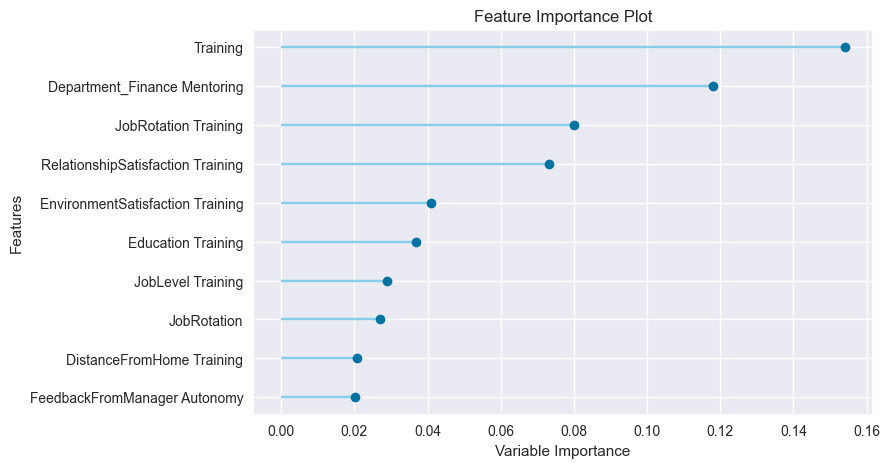

--- Feature Importance for: Random Forest Regressor ---


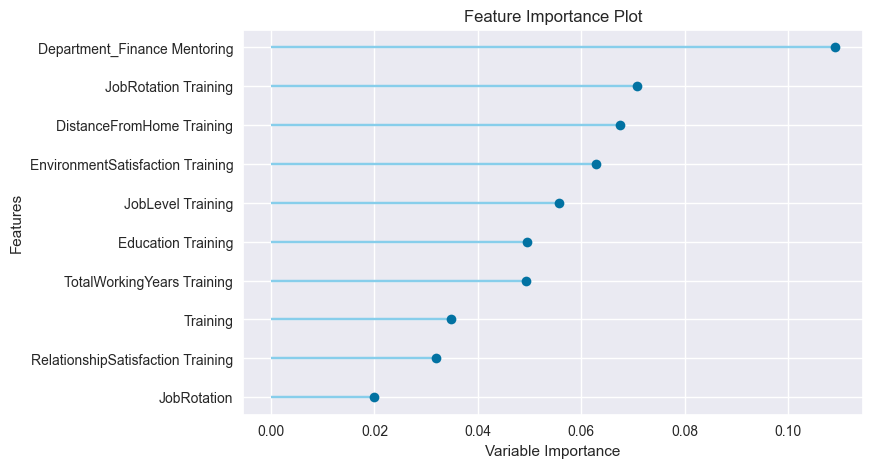

--- Feature Importance for: Gradient Boosting Regressor ---


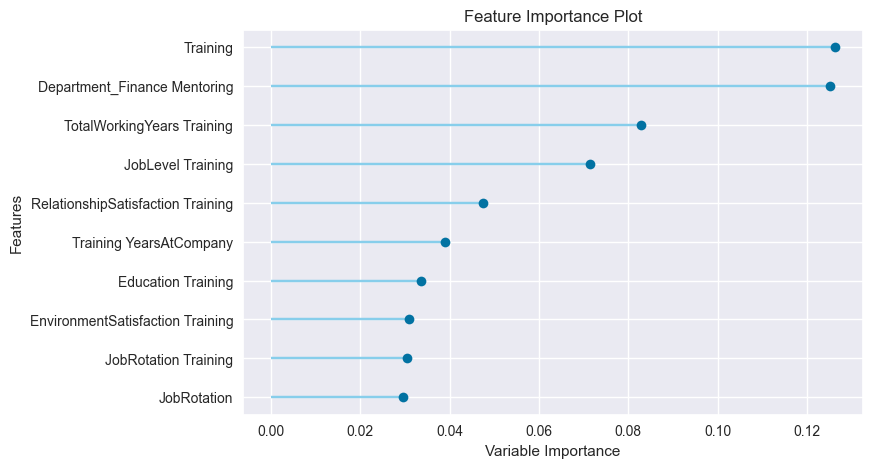

In [96]:
base_estimators = best_tuned.estimators_
estimator_names = [name for name, model in best_tuned.estimators]

for i, model in enumerate(base_estimators):
    print(f"--- Feature Importance for: {estimator_names[i]} ---")
    try:
        plot_model(model, plot='feature')
    except Exception as e:
        print(f"Could not generate plot for {estimator_names[i]}: {e}")